In [5]:
# -*- librerias --*-
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import dump
from surprise import Reader, accuracy, Dataset, KNNWithMeans
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNBasic, KNNBaseline, SVD

# Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

# -*- funciones --*-
def evaluate_models(models, test_set):
    results = {}
    
    for name, model in models.items():
        test_predictions = model.test(test_set)
        rmse = accuracy.rmse(test_predictions, verbose=False)
        
        # Comparar la predicción con una observación del test_set
        example_prediction = test_predictions[1]  # Tomamos la primera predicción como ejemplo
        real_rating = example_prediction.r_ui
        predicted_rating = example_prediction.est
        difference = abs(real_rating - predicted_rating)
        
        results[name] = {
            'RMSE': rmse,
            'RealRating': real_rating,
            'PredictedRating': predicted_rating,
            'Difference': difference
        }
    
    return results

def train_models(train_set, test_set, user_based=True):
    models = {}
    # Entrenar modelo con similitud coseno
    sim_options_cosine = {'name': 'cosine', 'user_based': user_based}
    model_cosine = KNNWithMeans(k=100, min_k=50, sim_options=sim_options_cosine)
    model_cosine.fit(trainset=train_set)
    models['cosine'] = model_cosine

    # Entrenar modelo con similitud de Pearson
    sim_options_pearson = {'name': 'pearson', 'user_based': user_based}
    model_pearson = KNNWithMeans(k=100, min_k=50, sim_options=sim_options_pearson)
    model_pearson.fit(trainset=train_set)
    models['pearson'] = model_pearson
    
    # Evaluamos los modelos
    results = evaluate_models(models, test_set)
    
    return models, results


# -*- rutas --*-
data_path = '../data/'
# Lista de archivos JSON y sus correspondientes nombres
files = {
    'yelp_academic_dataset_review.json': 'review',
    'yelp_academic_dataset_business.json': 'business',
    'yelp_academic_dataset_user.json': 'user'
}

In [15]:
# Define el tamaño del fragmento
chunk_size = 5000000  # Ajusta esto según la capacidad de memoria de tu sistema

# Define la ruta a los archivos JSON
data_path = data_path  # Ajusta esto a la ruta de tus archivos

# Diccionario para almacenar los DataFrames
dataframes = {}

# Procesa cada archivo
for file_name, df_name in files.items():
    # Ruta al archivo JSON
    file_path = f'{data_path}/{file_name}'

    # Lee el primer fragmento del archivo JSON
    json_reader = pd.read_json(file_path, lines=True, chunksize=chunk_size)
    first_chunk = next(json_reader)

    # Guarda el fragmento en el diccionario con el nombre correspondiente
    dataframes[df_name] = first_chunk

In [18]:
print(dataframes['business'].shape)
print(dataframes['review'].shape)
print(dataframes['user'].shape)


(8057, 14)
(624822, 9)
(354070, 22)


In [16]:
# -*- Filtrar negocios de interes --*-
# Valores sin nas
dataframes['business'] = dataframes['business'].dropna(subset=['categories'])
# Negocios abiertos
dataframes['business'] = dataframes['business'][dataframes['business']['is_open'] == 1] 
# Lista de palabras clave
keywords = ['Gastropubs', 'Nightlife', 'Bars', 'Cocktail Bars', 'Karaoke', 'Brewpubs', 'Pubs', 'Lounges', 'Whiskey Bars', 'Irish Pub', 'Beer Bar', 'Sports Bars', 'Wine Bars']
# Filtrar las filas que contienen las palabras clave en la columna 'categories'
dataframes['business'] = dataframes['business'][dataframes['business']['categories'].str.contains('|'.join(keywords))]

# Filtrar las filas anteriores a 2017
dataframes['review'] = dataframes['review'][pd.to_datetime(dataframes['review']['date']).dt.year >= 2017]

# Calcula el percentil 25 de la variable review_count
percentile_25 = dataframes['business']['review_count'].quantile(0.25)

# Filtra las filas que cumplen la condición
dataframes['business'] = dataframes['business'][dataframes['business']['review_count'] >= percentile_25]

# -*- Filtrar reviews de interes --*-
dataframes['review'] = dataframes['review'][dataframes['review']['business_id'].isin(dataframes['business']['business_id'])]

# -*- Filtrar usuarios de interes --*-
dataframes['user'] = dataframes['user'][dataframes['user']['user_id'].isin(dataframes['review']['user_id'])]

# -*- Guardar los DataFrames filtrados --*-
dataframes['business'].to_csv('../data/business_filtered.csv', index=False)
dataframes['review'].to_csv('../data/review_filtered.csv', index=False)
dataframes['user'].to_csv('../data/user_filtered.csv', index=False)

In [2]:
# -*- Leer los DataFrames filtrados --*-
business_filtered = pd.read_csv('../data/business_filtered.csv')
review_filtered = pd.read_csv('../data/review_filtered.csv')
user_filtered = pd.read_csv('../data/user_filtered.csv')

# -*- Imprimir la forma de los DataFrames filtrados --*-
print(business_filtered.shape)
print(review_filtered.shape)
print(user_filtered.shape)

(8057, 14)
(624822, 9)
(354070, 22)


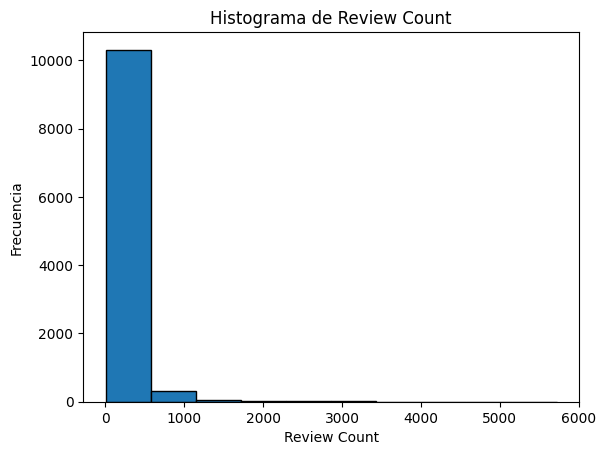

In [26]:
# Obtener los valores de la variable review_count
review_counts = business_filtered['review_count']

# Crear el histograma
plt.hist(review_counts, bins=10, edgecolor='black')

# Personalizar el gráfico
plt.title('Histograma de Review Count')
plt.xlabel('Review Count')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()


In [28]:
summary = business_filtered['review_count'].describe()
print(summary)

count    10725.000000
mean       137.100326
std        242.205986
min          5.000000
25%         20.000000
50%         59.000000
75%        158.000000
max       5721.000000
Name: review_count, dtype: float64


In [3]:
review_filtered.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,meGaFP7yxQdjyABrYDVeoQ,_jaJDV-qTBafatbObmtzpA,cg4JFJcCxRTTMmcg9O9KtA,1,0,1,0,Skip this train wreck if you are looking for d...,2018-02-11 03:11:20
2,xumAI7br1X67OY_bU_Yqhg,jEmClJb6wjfDUksVMO_Jjg,X_E7U2lVNEwbH_gpOBmAHQ,5,0,0,0,This place was so chill and relaxing. When I c...,2017-06-17 17:46:55
3,FMFZoES5LfumuwhsZbIDlQ,4ubLHlnMFFw4JikcXr-F4w,f4PA-f1tcN1bIpZJLdFsQQ,5,3,0,0,"I must admit, I wasn't expecting much. This pl...",2017-05-26 02:32:01
4,e4H9r1BSvBGAVQ-HvelnhA,1wN_Q-1fg46ZomOzf2tg5w,6p07zfmJWvytr0paqpyvbg,1,1,0,0,Worst place I've ever visited. The bouncer was...,2017-10-11 03:53:10


In [6]:
# Creacion obj reade
reader = Reader(rating_scale = (1, 5))
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df(review_filtered[['user_id', 'business_id', 'stars']], reader)
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)
print(train_set.n_ratings)
print(len(test_set))



499857
124965


In [7]:
# Entrenar modelos usuario-usuario
models, results = train_models(train_set, test_set)

: 

In [ ]:
# Imprimir los resultados de la evaluación
for model_name, result in results.items():
    print(f"Modelo: {model_name}")
    print(f"RMSE: {result['RMSE']}")
    print(f"Valor real: {result['RealRating']}")
    print(f"Valor predicho: {result['PredictedRating']}")
    print(f"Diferencia entre predicción y valor real de la primera observación del test set: {result['Difference']}")
    print()